In [1]:
# Load model directly
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from data.data import Delpher, DBNL
from accelerate.test_utils.testing import get_backend
from langchain_text_splitters import RecursiveCharacterTextSplitter
import pandas as pd
import pickle

In [ ]:
# around 200/300 is a good cutoff (using 250)

In [2]:
model_id = "GroNLP/gpt2-small-dutch"
device, _, _ = get_backend() 
model = AutoModelForCausalLM.from_pretrained(model_id)
max_len = 1024
tokenizer = AutoTokenizer.from_pretrained(model_id, max_length=max_len)

# Assign the EOS token as the padding token
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))

Embedding(40000, 768)

In [3]:
years = [1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819]
ds_delpher = Delpher().dataset.filter(lambda example: example["Year"] in years and len(example["CleanedText"])>100)
texts = ds_delpher['CleanedText']

In [4]:
print(len(texts))

81990


In [ ]:
def compute_perplexity_for_batch(input_texts):
    inputs = tokenizer(
        input_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_len
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    shift_logits = logits[:, :-1, :] 
    shift_labels = input_ids[:, 1:] 

    log_probs = torch.nn.functional.log_softmax(shift_logits, dim=-1)
    target_log_probs = log_probs.gather(dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)
    target_log_probs = target_log_probs * attention_mask[:, 1:].to(log_probs.dtype)
    negative_log_likelihood = -target_log_probs.sum(dim=-1) / attention_mask[:, 1:].sum(dim=-1)
    perplexities = torch.exp(negative_log_likelihood)
    # mean_perplexity_score = torch.mean(perplexities)
    
    return perplexities.tolist()
    # return {
    #     "perplexities": perplexities.tolist(),
    #     "mean_perplexity": mean_perplexity_score.item()
    # }

In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    model_name="gpt-2", chunk_size=max_len, chunk_overlap=0
)

In [ ]:
# text_splits = []
# for x in texts:
#     text_splits.append(text_splitter.split_text(x))

In [ ]:
# with open('perplexities_delpher/text_splits.pkl', 'wb') as p:
#     pickle.dump(text_splits, p)

In [ ]:
with open('perplexities_delpher/text_splits.pkl', 'rb') as p:
    text_splits = pickle.load(p)
print(len(text_splits))

In [ ]:
# change j AND savelen when needed
j = 200
save_len = 200
out = []
for i in text_splits[:600]:
    # print(len(i))
    out.append(compute_perplexity_for_batch(i))
    j += 1
    if j%save_len==0:
        with open(f"perplexities_delpher/{j}.pkl", 'wb') as b:
            pickle.dump(out, b)
        out = []
    if j%10==0:
        print(f"At {j}")
with open(f"perplexities_delpher/{j}.pkl", 'wb') as b:
    pickle.dump(out, b)

## Filter out anything which has a higher perplexity than 250

In [29]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

perplexities = []
# paths = glob.glob('perplexities_dbnl_plakaatboek*')
paths = glob.glob('perplexities_delpher/[0-9]*')
paths = sorted(paths, key=lambda x: int(x.rsplit('\\', 1)[-1].split('.')[0]))

for path in paths:
    with open(path, 'rb') as b:
        perplexities.extend(pickle.load(b))

In [30]:
avg_perplexities_delpher = [np.mean(x) for x in perplexities]

In [32]:
delpher_df = ds_delpher.to_pandas()
delpher_df = delpher_df[:len(avg_perplexities_delpher)]
delpher_df['perplexity'] = avg_perplexities_delpher

In [36]:
filtered_delpher = delpher_df[delpher_df['perplexity']<200]

In [37]:
# I think delpher is really hopeless for now
filtered_delpher

,Year,Month,Day,Newspaper,Path,Title,Text,CleanedText,perplexity
13,1805,9,6,Bataafsche staats-courant,1805/09/06/DDD_ddd_010084055_mpeg21/DDD_010084...,GENERLAITEITS NU BATAAFSCHE 99fte LOTERIJ.,Zesde Clcisfe. Prijzen en Premien van f ace en...,Zesde Clcisfe. Prijzen en Premien van f ace en...,168.024811
120,1805,9,27,Bataafsche staats-courant,1805/09/27/DDD_ddd_010084065_mpeg21/DDD_010084...,,"BEKENDMAKING. Ingevolge authorifatie, en onder...","BEKENDMAKING. Ingevolge authorifatie, en onder...",70.573433
121,1805,9,27,Bataafsche staats-courant,1805/09/27/DDD_ddd_010084065_mpeg21/DDD_010084...,,Volgens de Duitfche berigten to; den 2*. E-rce...,Volgens de Duitfche berigten to; den 2*. E-rce...,167.287399
122,1805,9,28,Bataafsche staats-courant,1805/09/28/DDD_ddd_010084066_mpeg21/DDD_010084...,BATAAFSCHE REPUBLIEK.,DEN HAAG den 28 September. Bij Hunne Hoog Moge...,DEN HAAG den 28 September. Bij Hunne Hoog Moge...,167.721436
156,1805,10,7,Bataafsche staats-courant,1805/10/07/DDD_ddd_010084071_mpeg21/DDD_010084...,TEXT DER NOTA VAN HET WEENER HOF.,„ Het Weener-Hof bewilligt zonder aarfelen in ...,Het Weener-Hof bewilligt zonder aarfelen in d...,165.788528
162,1805,10,7,Bataafsche staats-courant,1805/10/07/DDD_ddd_010084071_mpeg21/DDD_010084...,SPANJEN.,"MADRID den g September. De demisfie, door den ...","MADRID den g September. De demisfie, door den ...",192.234344
180,1805,10,7,Bataafsche staats-courant,1805/10/07/DDD_ddd_010084072_mpeg21/DDD_010084...,DUITSCHLAND.,-WEENEN den 24 September. Bij Publicatie der r...,-WEENEN den 24 September. Bij Publicatie der r...,133.634305
183,1805,10,9,Bataafsche staats-courant,1805/10/09/DDD_ddd_010084073_mpeg21/DDD_010084...,RUSLAND.,PETERSBURG den 18 September. De Luitenant-Gene...,PETERSBURG den 18 September. De Luitenant-Gene...,165.736359
192,1805,10,11,Bataafsche staats-courant,1805/10/11/DDD_ddd_010084074_mpeg21/DDD_010084...,GROOT-BRITTANNIEN.,LONDEN den 5 Oclober. De tijding der wegneming...,LONDEN den 5 Oclober. De tijding der wegneming...,172.123856
216,1805,10,16,Bataafsche staats-courant,1805/10/16/DDD_ddd_010084076_mpeg21/DDD_010084...,EXTRACT UIT HET REGISTER DER RESOLUTIEN VAN HE...,"Dingsdag, den 4 Junij 1805. Commisfarisfen tot...","Dingsdag, den 4 Junij 1805. Commisfarisfen tot...",161.257013


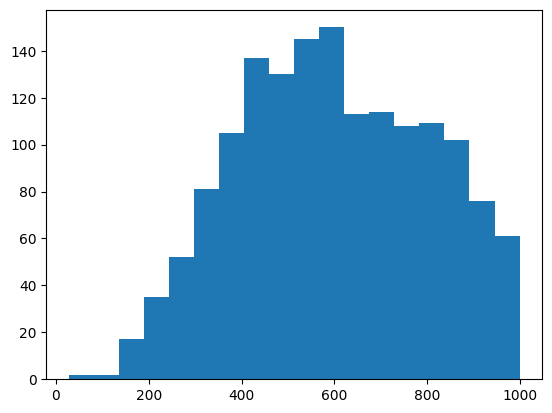

In [34]:
plt.hist([x for x in avg_perplexities_delpher if x<1000], bins="auto")
plt.show()